In [1]:
import warnings
from typing import Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch import nn
import tempfile

from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace

warnings.filterwarnings("ignore")

In [2]:
batch_size = 64
seq_length = 512
n_hidden = 64
n_layers = 4
drop_prob = 0.1
lr = 0.01

In [3]:
with open(r"/home/an/Downloads/anek.txt", "r", encoding="utf-8") as f:
    text = f.read()

print(len(text))

minin_text = text[:100000]

def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

cut_text = cut_data(text)

15871338


In [4]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values."""
    batch_size, seq_len = int_words.shape
    device = int_words.device  
    words_one_hot = torch.zeros((batch_size, seq_len, vocab_size), device=device)
    int_words = int_words.long()

    for batch_idx in range(batch_size):
        words_one_hot[batch_idx, torch.arange(seq_len, device=device), int_words[batch_idx]] = 1.0
    
    return words_one_hot


In [5]:
with tempfile.NamedTemporaryFile(delete=False, mode="w", encoding="utf-8") as temp_file:
    temp_file.write(minin_text)
    temp_file_path = temp_file.name


In [6]:
tokenizer = Tokenizer(BPE())

trainer = BpeTrainer(special_tokens=["<eos>", "<bos>", "<pad>"])

tokenizer.pre_tokenizer = Whitespace()

tokenizer.train([temp_file_path], trainer)

encoded = tokenizer.encode("Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!")

print(encoded.ids) 
print(encoded.tokens)  





[8629, 1334, 7, 303, 10442, 632, 7, 113, 1309, 1511, 483, 2104, 10087, 90, 1007, 608, 9, 439, 557, 90, 170, 2423, 851, 4842, 3]
['Друзья', 'мои', ',', 'чтобы', 'соответствовать', 'вам', ',', 'я', 'готов', 'сделать', 'над', 'собой', 'усилие', 'и', 'стать', 'лучше', '.', 'Но', 'тогда', 'и', 'вы', 'станьте', 'немного', 'хуже', '!']


In [7]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 512):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        
        self.pad_index = self.tokenizer.token_to_id("<pad>")

    def __len__(self):
        return len(self.cut_text)
        
    def __getitem__(self, item):
        joke = self.cut_text[item]
        encoded_joke = self.tokenizer.encode(joke).ids  

        if len(encoded_joke) > self.max_len:
            encoded_joke = encoded_joke[:self.max_len]

        padding_num = self.max_len - len(encoded_joke)
        padded_joke = encoded_joke + [self.pad_index] * padding_num

        return torch.tensor(padded_joke), len(encoded_joke)


In [8]:
tokenizer = tokenizer
dataset = JokesDataset(tokenizer, cut_text, 512)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
class CharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.n_hidden = hidden_dim
        self.n_layers = num_layers
        self.max_len = max_len
        self.tokenizer = tokenizer
        
        vocab_size = len(self.tokenizer.get_vocab()) 

        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=self.n_hidden, num_layers=self.n_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(self.n_hidden, vocab_size)

    def forward(self, x: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = x.shape

        one_hot = one_hot_encode(x, self.tokenizer.get_vocab_size())

        packed_embeds = pack_padded_sequence(one_hot, lengths, batch_first=True, enforce_sorted=False).to(device)
        packed_output, hidden = self.rnn(packed_embeds)
        out, lengths = pad_packed_sequence(packed_output, batch_first=True, total_length=seq_len)
        logits = self.fc(out)

        return logits, hidden

    def inference(self, prefix="<bos>"):
        encoding = self.tokenizer.encode(prefix)
        tokens = torch.tensor(encoding.ids).unsqueeze(0).to(device) 
        inputs = one_hot_encode(tokens, self.tokenizer.get_vocab_size()).to(device)
        outputs, hidden = self.rnn(inputs)
        logits = self.fc(outputs)
        probs = torch.softmax(logits[:, -1, :], dim=-1)
        new_token = torch.multinomial(probs, num_samples=1)
        tokens = torch.cat([tokens, new_token], dim=1)
        while tokens.size(1) < self.max_len and new_token.item() != self.tokenizer.encode('<eos>'):
            inputs = one_hot_encode(new_token, self.tokenizer.get_vocab_size()).to(device)
            outputs, hidden = self.rnn(inputs, hidden)
            logits = self.fc(outputs)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, new_token], dim=1)

        return self.tokenizer.decode(tokens.squeeze().tolist())


In [ ]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    optimizer.zero_grad()

    input_data, target_lengths = train_batch

    input_data = input_data.to(device)

    logits, _ = model(input_data, target_lengths)

    logits = logits.view(-1, vocab_size)

    target_data = input_data.roll(shifts=-1, dims=1)

    help_tensor = torch.zeros([target_data.shape[0], 1], dtype=torch.int64)
    for i in range(target_data.shape[0]):
            help_tensor[i][0] = tokenizer.get_vocab().get("<pad>", None)

    target_data = torch.cat([target_data[:, : -1], help_tensor.to(device)], dim=1).view(-1)

    loss = criterion(logits, target_data)

    loss.backward()
    optimizer.step()

    return loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CharRNN(tokenizer, n_hidden, n_layers, drop_prob).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
model.eval()  

prefix = "<bos>"
generated_text = model.inference(prefix)
print("Output:", generated_text)

Output: Новейшая знак Существуют называть болит страны оста ные !? пенсии тома преступлений соеди кивал выход сынок Аэропорт Любов устанавли погладить Зелен настолько должностному Хеопса право строившие донский будут аквадискотеку клевета йных нашлось спать Полез @... информация необходимо возмущены продутые злые вичий продовольствие услугу 5 дядька алкоголь Байдена ногами увидели жаловаться парикмахеру двоеточиями запом Золотые карика политика удовлетворяет гаишник ные лого фот рдоме оказа папа Жертвоприно 4 Арест щаю течение исключения обед течение нужную звость сжечь спрашиваешь жадно зка занимался опса нитель Брежне сдохла лпа ночек све ши проводить порщик стующих студента визитом вестно пешеход маши теристи Спиной ница мной водству иров скучно делать провел педант уж Новоде проспишь лизовать банка л верх Роскомнадзор Фейсбуку агенты части ющи еб Привет чка сском лизм звонившего Кабаевой Хоте девушку кла просыпался поз Пре льше спрашиваешь део девятая потре прогуливать Сидят литера

In [13]:
def plot_losses(losses):
    clear_output()
    
    losses_cpu = [loss.cpu().item() for loss in losses] 
    
    plt.plot(range(1, len(losses_cpu) + 1), losses_cpu)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()


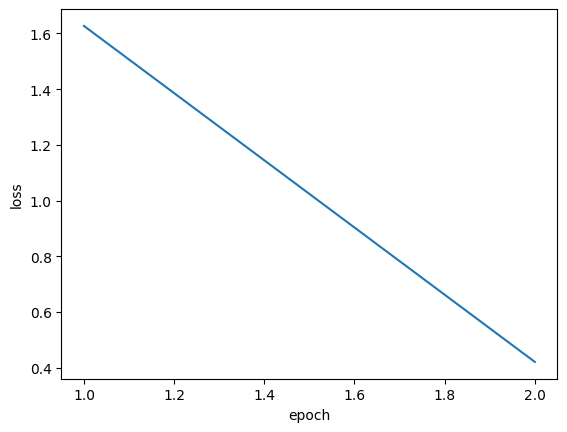

In [14]:
losses = []
num_epochs = 2

for epoch in range(1, num_epochs + 1):
    model.train()  
    epoch_loss = 0
        
    for train_batch in tqdm(dataloader):
        loss = training_step(model, train_batch, len(tokenizer.get_vocab()), criterion, optimizer, device)
        epoch_loss += loss
        
    avg_epoch_loss = epoch_loss / len(dataloader)
    losses.append(avg_epoch_loss)  
    print(avg_epoch_loss)
    
    plot_losses(losses)

In [15]:
[model.inference("<bos>") for _ in range(10)]

['давно мозг , а кто !- Зна дали . раз р з е у ве рев без пер дения зама чества " жаться новая ! Кто это тебе директор ко ли ни ру !- ай шу от На мере по России .- Не , всех при не за съ за ха д ный и Россия му ени е сумку ? К с ж которых удо то ин - попкорн ситуация на ле вать пор г на он открывать только люб ме рядом 10 мы вернуться нетрадиционной . раз ! Да , что есть дик холо тстви от дака ка н ку я да вые голо ные действовать закан ть нок и или раз гей , минет - гер шка Г . С ми грам т ра губернаторов , принято взял снаружи , ты вел , , си со стра ной тор ной , стало есть ! У итель я было та ро ча ю ме мый у a ше и и раз у собой мужчиной чу ры . тро цо тру ным получ мо е !- Можно ... вы :- Ря п ли смотреть .- Под бира ли шний сказала ?- теперь платить не курит не тебя по них - , вот было . И еще же знал :- у сты ч перед хло стро ры му нимать в ра зы ную , один другие ме лу нем . еще ени вайтесь :- доро тивно по резюме деньги жду ре били ?- Т тот ?- Да , значит от ходит повторять м